# Chapter 5: Support Vector Machines

## Exercises

### 1) What is the approximate depth of a decision tree trained (without restrictions) on a training set with one million instances?

The depth of a well-balanced binary tree containing m leaves is equal to log₂(m), rounded up. log₂ is the binary log; log₂(m) = log(m) / log(2). A binary Decision Tree (one that makes only binary decisions, as is the case with all trees in Scikit-Learn) will end up more or less well balanced at the end of training, with one leaf per training instance if it is trained without restrictions. Thus, if the training set contains one million instances, the Decision Tree will have a depth of log₂(106) ≈ 20 (actually a bit more since the tree will generally not be perfectly well balanced).

### 2) Is a node's Gini impurity generally lower or higher that its parents? Is it generally lower/higher, or always lower/higher ?

The Gini impurity is calculated by: $ G_1 = 1 - \sum\limits_{k=1}^{n}p_i,k^2$, where $ p_i,k^2$ is the ratio of class _k_ instances among the training instances in the _i^th_ node.
<br> Since the Parent class has all the classes the Gini will be higher compared to the chields, since will be childs only with one class. So the answer is, it will be always lower.

### 3) If a decision tree is overfitting the training set, it it good idea to try decreasing max_depth?

Yes, the max_depth hyperparameter  will limiter the depth of the model, constraint

### 4) If a decision tree is underfitting the training set, is it a good idea to trey to scale the input data?

One advantage of decision trees is that they don´t require scalling the input data, so it will have no impact on the training

### 7) Train and fine-tune a decision tree for the moons dataset

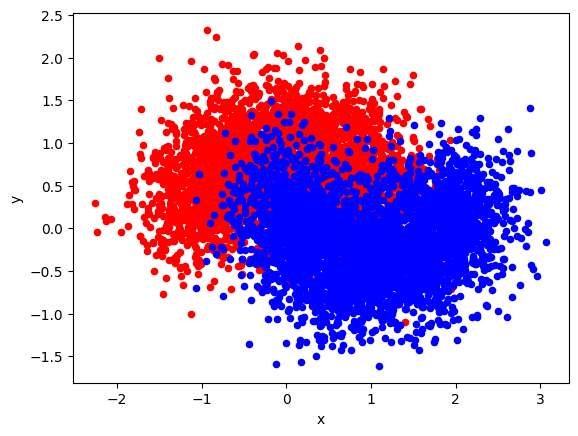

In [19]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


# Create dataset
X_moons, y_moons = make_moons(n_samples=10_000, noise=0.4)

# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size=0.3, shuffle=True, random_state=42)

# Plot
df = pd.DataFrame(dict(x=X_train[:, 0], y=X_train[:, 1], label=y_train))
colors = {0:"red", 1:"blue"}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind="scatter", x="x", y="y", color=colors[key])
plt.show()

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)

# Param grid
param_grid = {
    'max_leaf_nodes': list(range(2, 100)),
    'max_depth': list(range(1, 7)),
    'min_samples_split': [2, 3, 4]
}

tree_search = GridSearchCV(tree_clf, param_grid, cv=3)
tree_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]})

In [23]:
print(tree_search.best_score_)
print(tree_search.best_estimator_)

0.8509983614993107
DecisionTreeClassifier(max_depth=4, max_leaf_nodes=12, random_state=42)


In [27]:
from sklearn.metrics import accuracy_score

y_pred = tree_search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8546666666666667


### 8) Grow a forest by following these steps

In [46]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, ShuffleSplit


# Create dataset
X_moons, y_moons = make_moons(n_samples=10_000, noise=0.4)

# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size=0.3, shuffle=True, random_state=42)

# 1k subsets each containing 100 instances
random_split = ShuffleSplit(n_splits=1000, train_size=100, random_state=42)

mini_sets = []
for mini_x_train_index, _ in random_split.split(X_train):
    X_mini_train = X_train[mini_x_train_index]
    y_mini_train = y_train[mini_x_train_index]
    mini_sets.append((X_mini_train, y_mini_train))


Train one decision tree on each subset

In [47]:
from sklearn.base import clone
import numpy as np


# Clone the best Hyperparameters
forest = [clone(tree_search.best_estimator_) for _ in range(1000)]

# Train each model
accuracy_scores = []
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8040526666666667

Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's mode() function for this). This gives you majority-vote predictions over the test set.

In [48]:
Y_pred = np.empty([1000, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [52]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, keepdims=True)

In [53]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.8573333333333333